In [1]:


#fetch command line argument (prepped model)
#%reset
import sys
import os
from copy import deepcopy
import pickle
import torch
import plotly.offline as py
import plotly.graph_objs as go

os.chdir('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/')



sys.path.insert(0, os.path.abspath('./prep_model_scripts/'))
sys.path.insert(0, os.path.abspath('./visualizer_scripts/'))
from visualizer_helper_functions import *
from contrast_helper_functions import *
from featureviz_helper_functions import *
from subgraph_helper_functions import *
from ablation_functions import *
from receptive_field import *
from dissected_Conv2d import *
from copy import deepcopy


py.init_notebook_mode(connected=True)   #jupyter notebook only

prepped_model_folder = 'alexnet_sparse'    #set this to a subfolder of prunned_models

full_prepped_model_folder = os.path.abspath('prepped_models/%s'%prepped_model_folder)

possible_models = os.listdir('prepped_models')
print('possible models to visualizer are:')
print(possible_models)

print('\nYou\'ve chosen to visualize %s'%prepped_model_folder)


sys.path.insert(0,'prepped_models/%s'%prepped_model_folder)

import prep_model_params_used as prep_model_params

params = {}
params['prepped_model'] = prepped_model_folder
params['prepped_model_path'] = full_prepped_model_folder
params['device'] = 'cuda:0'
params['deepviz_neuron'] = True
params['deepviz_edge'] = False

#Parameters

#Non-GUI parameters

#deepviz
params['deepviz_param'] = None
params['deepviz_optim'] = None
params['deepviz_transforms'] = None
params['deepviz_image_size'] = prep_model_params.deepviz_image_size

#backend
params['cuda'] = prep_model_params.cuda    #use gpu acceleration when running model forward
params['input_image_directory'] = prep_model_params.input_img_path+'/'   #path to directory of imput images you want fed through the network
params['preprocess'] = prep_model_params.preprocess     #torchvision transfrom to pass input images through
params['label_file_path'] = prep_model_params.label_file_path
params['criterion'] = prep_model_params.criterion
params['rank_img_path'] = prep_model_params.rank_img_path
params['num_workers'] = prep_model_params.num_workers
params['seed'] = prep_model_params.seed
params['batch_size'] = prep_model_params.batch_size
#params['dynamic_act_cache_num'] = 4  #max number of input image activations 'dynamic_activations' will have simultaneously

 
#aesthetic 

params['node_size'] = 12
params['edge_size'] = 1
params['max_node_inputs'] = 10    #there is a dropdown showing the top weighted edge inputs to nodes, how many maps in dropdown?
params['layer_colors'] = ['rgba(31,119,180,', 
                          'rgba(255,127,14,',
                          'rgba(44,160,44,', 
                          'rgba(214,39,40,',
                          'rgba(39, 208, 214,', 
                          'rgba(242, 250, 17,',
                          'rgba(196, 94, 255,',
                          'rgba(193, 245, 5,',
                          'rgba(245, 85, 5,',
                          'rgba(5, 165, 245,',
                          'rgba(245, 5, 105,',
                          'rgba(218, 232, 23,',
                          'rgba(148, 23, 232,',
                          'rgba(23, 232, 166,',]


#visibility

params['show_ablations'] = False    #show network ablations modules
params['show_act_map_means'] = False #show mean value under activation maps
params['show_image_manip'] = False

#GUI parameters initialization (these parameters can be set in the GUI, but what values should they be initialized to?)
target_category = 'overall'     #category of images edges and nodes are weighted based on (which subgraph) 
rank_type = 'actxgrad'       #weighting criterion (actxgrad, act, grad, or weight)
projection = 'MDS smooth'           #how nodes within a layer are projected into the 2d plane (MDS or Grid)
edge_threshold = [.7,1]     #what range do edge ranks need to be in to be visualized
node_threshold = [.4,1]     #only relevant for hierarchical subgraph 

#### DONT EDIT BELOW initializations

figure_init = go.Figure()
figure_init.add_trace(go.Scatter(
            x=[],
            y=[]))
figure_init.update_layout(xaxis=dict(visible=False),
                  yaxis=dict(visible=False),
                  annotations = [dict(text="No Inputs",
                                      xref="paper",
                                      yref="paper",
                                      showarrow=False,
                                      font=dict(size=28))]
                 )

params['max_edge_weight'] = 1  #for the edge threshold slider, this dynamically adjusted its max value to max edge rank
                     #before there were multiple rank criterions, which made things confusing
                     #so well just fix it to 1 for now
        
        
display_dict = {True:'block',False:'none'}


#load Model

model_dis = dissect_model(deepcopy(prep_model_params.model),store_ranks=True,clear_ranks=True,cuda=params['cuda'],device=params['device']) #version of model with accessible preadd activations in Conv2d modules 
if params['cuda']:
    model_dis.cuda()
model_dis = model_dis.eval()    
model_dis.to(params['device'])

print('loaded model:')
print(prep_model_params.model)
        
#del prep_model_params.model
model = prep_model_params.model
if params['cuda']:
    model.cuda()
model = model.eval()
model.to(params['device'])


#load misc graph data
print('loading misc graph data')
misc_data = pickle.load(open('./prepped_models/%s/misc_graph_data.pkl'%prepped_model_folder,'rb'))
params['layer_nodes'] = misc_data['layer_nodes']
params['num_layers'] = misc_data['num_layers']
params['num_nodes'] = misc_data['num_nodes']
params['categories'] = misc_data['categories']
params['num_img_chan'] = misc_data['num_img_chan']
params['imgnode_positions'] = misc_data['imgnode_positions']
params['imgnode_colors'] = misc_data['imgnode_colors']
params['imgnode_names'] = misc_data['imgnode_names']
params['prepped_model_path'] = full_prepped_model_folder
params['ranks_data_path'] = full_prepped_model_folder+'/ranks/'


kernels = torch.load('prepped_models/%s/kernels.pt'%prepped_model_folder)['kernels']
kernel_colors = torch.load('prepped_models/%s/kernels.pt'%prepped_model_folder)['kernel_colors']


possible models to visualizer are:
['mnist_resize', 'alexnet_old.tar.gz', 'mnist_old', '.keep', 'mnist', 'old', 'alexnet10', 'letter_mixed_not_trained', 'imagenet10_sparse', 'alexnet_sparse_test', '.DS_Store', 'alexnet_sparse_full_model_10classes', 'alexnet_sparse.tar.gz', 'imagenet10', 'alexnet_sparse', 'alexnet_lucent', 'mnist.tgz', 'alexnet', 'letter_mixed', 'googlenet10_test', '._.DS_Store', 'alexnet_corrupted', 'alexnet.tar.gz']

You've chosen to visualize alexnet_sparse


/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning:


Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/




loaded model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096

In [2]:
kernel_colors[0].shape

(64, 3, 3)

In [3]:
subgraph_dict = torch.load('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/435_0.20.6.pt')

In [4]:
subgraph_dict

{'model': Sequential(
   (conv_0): Conv2d(3, 2, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (relu_1): ReLU()
   (pool_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_1): Conv2d(2, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (relu_2): ReLU()
   (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_2): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ),
 'gen_params': {'node_thresh': 0.2,
  'edge_thresh': 0.6,
  'input': 'small_SPAN',
  'output': '435'},
 'node_df':     node_num  layer_name layer node_num_by_layer  act_rank  grad_rank  \
 21        21  features_0     0                21  0.418738   1.000000   
 37        37  features_0     0                37  0.541165   0.384474   
 75        75  features_3     1                11  0.262501   1.000000   
 198      198  features_3     1               134  0.572941   0.347770   
 244      244  features_3     1          

In [5]:
dissected_subgraph = dissect_model(subgraph_dict['model'])

In [6]:
dissected_subgraph

Sequential(
  (conv_0): dissected_Conv2d(
    (preadd_conv): Conv2d(3, 6, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), groups=3, bias=False)
  )
  (relu_1): ReLU()
  (pool_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): dissected_Conv2d(
    (preadd_conv): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2, bias=False)
  )
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): dissected_Conv2d(
    (preadd_conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
  )
)

In [7]:
subgraph_dict['edge_df']

,edge_num,layer_name,layer,out_channel,in_channel,act_rank,grad_rank,actxgrad_rank
64,64,features_0,0,21,1,7.995568,0.000083,0.000644
63,63,features_0,0,21,0,4.647471,0.000083,0.000360
112,112,features_0,0,37,1,7.880744,0.000034,0.000225
113,113,features_0,0,37,2,4.310708,0.000034,0.000123
65,65,features_0,0,21,2,3.609935,0.000083,0.000289
917,917,features_3,1,11,21,1.830545,0.000081,0.000304
8789,8789,features_3,1,134,21,3.371428,0.000028,0.000038
11749,11749,features_3,1,180,37,2.083190,0.000028,0.000122
46859,46859,features_6,2,179,11,1.420799,0.000947,0.001231
46982,46982,features_6,2,179,134,0.498226,0.000947,0.000494


In [8]:
subgraph_dict['node_df']

,node_num,layer_name,layer,node_num_by_layer,act_rank,grad_rank,actxgrad_rank
21,21,features_0,0,21,0.418738,1.000000,1.000000
37,37,features_0,0,37,0.541165,0.384474,0.514951
75,75,features_3,1,11,0.262501,1.000000,1.000000
198,198,features_3,1,134,0.572941,0.347770,0.400769
244,244,features_3,1,180,0.277107,0.342456,0.397590
435,435,features_6,2,179,0.244534,1.000000,1.000000


In [9]:
list(subgraph_dict['node_df'].loc[subgraph_dict['node_df']['layer']==0]['node_num'])

[21, 37]

In [11]:
def minmax_normalize_between_values(vec,min_v,max_v):
    return (max_v-min_v)*(vec-np.min(vec))/(np.max(vec)-np.min(vec))+min_v
    

    
    
    
def edge_width_scaling(x):
    #return max(.4,(x*10)**1.7)
    return max(.5,np.exp(1.5*x))
    
def subgraph_2_2d_circuit(subgraph_dict,params,rank_type = 'actxgrad_rank', num_hoverpoints=4,min_w=4,max_w=10):
    layer_offset = 5
    vert_offset = 1
    rank = 'actxgrad_rank'
    pos_dict_nodes = {}
    imgnode_positions = {'X':[-layer_offset,-layer_offset,-layer_offset],'Y':[2,0,-2]}
    #add img nodes
    imgnode_trace=go.Scatter(x=imgnode_positions['X'],
           y=imgnode_positions['Y'],
           mode='markers',
           name='image channels',
           marker=dict(symbol='square',
                         size=8,
                         opacity=.99,
                         color=params['imgnode_colors'],
                         #colorscale='Viridis',
                         line=dict(color='rgb(50,50,50)', width=.5)
                         ),
           text=params['imgnode_names'],
           hoverinfo='text'
           )

    imgnode_traces = [imgnode_trace]

    node_traces = []
    for layer in list(subgraph_dict['node_df']['layer'].unique()):
        #add nodes

        within_layer_ids = list(subgraph_dict['node_df'].loc[subgraph_dict['node_df']['layer']==layer]['node_num_by_layer'])
        scores = list(subgraph_dict['node_df'].loc[subgraph_dict['node_df']['layer']==layer][rank])
        ids = list(subgraph_dict['node_df'].loc[subgraph_dict['node_df']['layer']==layer]['node_num'])
        #print(np.dstack((ids,within_layer_ids,scores)).shape)
        #print(np.dstack((ids,within_layer_ids,scores)))
        # hovertext = ['<b>%{id}</b>' +
        # 			'<br><i>layerwise ID</i>: %{within_layer_id}'+
        # 			'<br><i>Score</i>: %{score}<br>'
        # 			 for id, within_layer_id, score in
        # 			 zip(ids, within_layer_ids, scores)]
        #print(hovertext) 
        x_positions = []
        y_positions = []
        y_adjustment = (len(within_layer_ids)-1)/2*vert_offset
        for i in range(len(within_layer_ids)):
            x_positions.append(layer*layer_offset)
            y_positions.append(i*vert_offset-y_adjustment)
        node_trace=go.Scatter(x=x_positions,
                   y=y_positions,
                   mode='markers',
                   name=list(subgraph_dict['node_df'].loc[subgraph_dict['node_df']['layer']==layer]['layer_name'].unique())[0],
                   marker=dict(symbol='circle',
                                 size=6,
                                 color='rgba(50,50,50,0)',
                                 opacity=0,
                                 #colorscale='Viridis',
                                 line=dict(color='rgba(50,50,50,0)', width=.5)
                                 ),
                   text=ids,
                   #customdata = np.dstack((ids,within_layer_ids,scores)),
                   customdata = np.stack((ids,within_layer_ids,scores),axis=-1),
                   hovertemplate =	'<b>%{customdata[0]}</b>' +
                            '<br><i>layerwise ID</i>: %{customdata[1]}'+
                            '<br><i>Score</i>: %{customdata[2]:.3f}<br>'
                   #hoverinfo='text'
                   )

        node_traces.append(node_trace)
        pos_dict_nodes[layer] = {'name':ids,'X':x_positions,'Y':y_positions}
        
    edge_df =  minmax_normalize_ranks_df(subgraph_dict['edge_df'],params)
    edge_traces = []
    pos_dict_edges = {}
    for layer in list(edge_df['layer'].unique()):  
        pos_dict_edges[layer] = {'name':[],'X':[],'Y':[]}
        legendgroup = layernum2name(layer ,title = 'edges')
        
        #edge_widths = []
        #names = []
        #colors = []
        for row in edge_df.loc[edge_df['layer']==layer].itertuples():
            showlegend = False
            if getattr(row, rank_type) > .999:
                showlegend = True
            #positions
            edge_positions = {'X':[],'Y':[]}
            for dim in ['X','Y']:
                end_pos = pos_dict_nodes[layer][dim][pos_dict_nodes[layer]['name'].index(params['layer_nodes'][layer][1][row.out_channel])]
                if layer != 0:
                    start_pos = pos_dict_nodes[layer-1][dim][pos_dict_nodes[layer-1]['name'].index(params['layer_nodes'][layer-1][1][row.in_channel])]
                else:
                    start_pos = imgnode_positions[dim][row.in_channel]

                step = (end_pos-start_pos)/(num_hoverpoints+1)
                points = [start_pos]
                for i in range(1,num_hoverpoints+1):
                    points.append(start_pos+i*step)
                points.append(end_pos)
                edge_positions[dim]=points
            #widths
            edge_width = edge_width_scaling(getattr(row, rank_type))
            #edge_widths.append(edge_width_scaling(getattr(row, rank_type)))
            #names
            out_node = params['layer_nodes'][row.layer][1][row.out_channel]
            if row.layer != 0:
                in_node = params['layer_nodes'][row.layer-1][1][row.in_channel]
            else:
                in_node = params['imgnode_names'][row.in_channel]
            #names.append(str(in_node)+'-'+str(out_node))
            edge_name = str(in_node)+'-'+str(out_node)
            #color
            if kernel_colors is None:
                alpha = edge_color_scaling(getattr(row, rank_type))
                #colors.append(params['layer_colors'][layer%len(params['layer_colors'])]+str(round(alpha,3))+')')
                edge_color = params['layer_colors'][layer%len(params['layer_colors'])]+str(round(alpha,3))+')'
            else:
                #colors.append(color_vec_2_str(kernel_colors[int(layer)][int(row.out_channel)][int(row.in_channel)]))
                edge_color = color_vec_2_str(kernel_colors[int(layer)][int(row.out_channel)][int(row.in_channel)])
            edge_trace=go.Scatter(x=edge_positions['X'],
                            y=edge_positions['Y'],
                            legendgroup=legendgroup,
                            showlegend=showlegend,
                            name=params['layer_nodes'][layer][0],
                            mode='lines',
                            #line=dict(color=edge_colors_dict[layer], width=1.5),
                            line=dict(color=edge_color, width=edge_width),
                            text = edge_name,
                            hoverinfo='text'
                            )
            edge_traces.append(edge_trace)
            pos_dict_edges[layer]['name'].append(edge_name)
            pos_dict_edges[layer]['X'].append(edge_positions['X'])
            pos_dict_edges[layer]['Y'].append(edge_positions['Y'])
    #trace just for storing data
    misc_trace=go.Scatter(x=[-layer_offset-.5],
                y=[-2.5],
                showlegend=False,
                name='misc',
                mode='markers',
                marker=dict(symbol='circle',
                 size=6,
                 color='rgba(255,255,255,0)',
                 opacity=0,
                 #colorscale='Viridis',
                 line=dict(color='rgba(255,255,255,0)', width=.5)
                 ),

                text = 'full', #text info storing full or partial graph
                hoverinfo='skip'
                )
    combined_traces = imgnode_traces+node_traces+edge_traces+[misc_trace]
    return combined_traces, pos_dict_nodes, pos_dict_edges



def circuit2d_curve_2_id(curve_num,point_num,subgraph_dict,params):
    if curve_num == 0:
        imgnode_dict = {0:'r',1:'g',2:'b'}
        return imgnode_dict[point_num]
    elif curve_num <= len(subgraph_dict['node_df']['layer'].unique()):
        layer = curve_num-1
        return str(subgraph_dict['node_df'].loc[subgraph_dict['node_df']['layer']==layer].iloc[point_num]['node_num'])
    else:
        edge_row_idx = curve_num - 1 - len(subgraph_dict['node_df']['layer'].unique())
        row = subgraph_dict['edge_df'].iloc[edge_row_idx]
        if row['layer'] != 0:
            in_node = params['layer_nodes'][row['layer']-1][1][row['in_channel']]
        else:
            in_node = params['imgnode_names'][row['in_channel']]
        out_node = params['layer_nodes'][row['layer']][1][row['out_channel']]
        return str(in_node)+'-'+str(out_node)
    

In [12]:
from scipy.spatial import distance_matrix

def min_distance(x,y,minimum=1):
    dist = np.linalg.norm(x-y)
    if dist > minimum:
        return dist,True
    else:
        return dist,False
    
    
def multipoint_min_distance(points):   #takes numpy array of shape (# points, # dimensions)
    dist_mat = distance_matrix(points,points)
    dist_mat[np.tril_indices(dist_mat.shape[0], 0)] = 10000
    print(dist_mat)
    return np.min(dist_mat)


points = np.array([[1,1],
                   [1,2],
                   [3,2]])

multipoint_min_distance(points)


[[1.00000000e+04 1.00000000e+00 2.23606798e+00]
 [1.00000000e+04 1.00000000e+04 2.00000000e+00]
 [1.00000000e+04 1.00000000e+04 1.00000000e+04]]


1.0

In [82]:
points.shape

(3, 2)

In [13]:
def gen_kernel_img(edge_name,kernels,params):
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, None, kernels, None,params)
    if kernel is not None:
        fig =  go.Figure(data=go.Heatmap(z = kernel,
                                         colorscale='RdBu',
                                         reversescale=True,
                                         zmid=0,
                                         #zmin=-.5,
                                         #zmax=.5,
                                        showscale=False),
                         layout=kernel_layout)
        fig.update(layout_showlegend=False)
        img_file_path = './prepped_models/%s//visualizations/images/kernels/%s.jpg'%(prepped_model_folder,str(edge_name))
        if not os.path.exists(img_file_path):
            fig.write_image(img_file_path)


In [14]:
circuit_layout = go.Layout(
         #title="%s through Prunned Cifar10 CNN"%target_category,
         #title = target_category,
         #width=1000,
         clickmode = 'event+select',
         transition = {'duration': 20},
         height=1300,
         #showlegend=False,
         margin = dict(l=20, r=20, t=20, b=20),  
         #hovermode='closest',
         paper_bgcolor='rgba(0,0,0,0)',
         plot_bgcolor='rgba(0,0,0,0)',
         xaxis=dict(showline=False,showgrid=False,showticklabels=False),
         yaxis=dict(showline=False,showgrid=False,showticklabels=False))


kernel_layout = go.Layout(
    #title='kernel'
    #autosize=False,
    width=50,
    height=50,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ),
    xaxis=dict(showline=False,showgrid=False,showticklabels=False),
    yaxis=dict(showline=False,showgrid=False,showticklabels=False))

In [15]:
gen_kernel_img('r-22',kernels,params)

In [24]:
#subgraph_name = '698_0.20.6.pt'
#subgraph_name = '837_0.20.6.pt'
subgraph_name = '99_0.40.7.pt'
subgraph_dict = torch.load('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/subgraphs/models/%s'%subgraph_name)

In [25]:
circuit_traces,pos_dict_nodes,pos_dict_edges = subgraph_2_2d_circuit(subgraph_dict,params)
circuit_fig=go.Figure(data=circuit_traces, layout=circuit_layout)


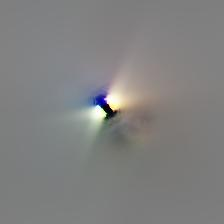
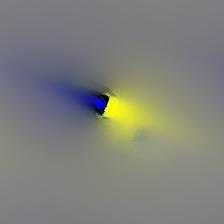
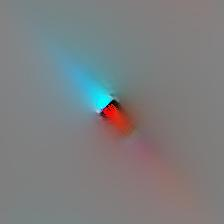
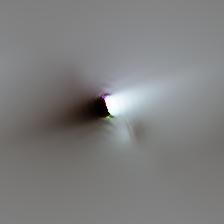
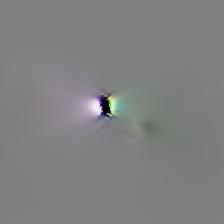
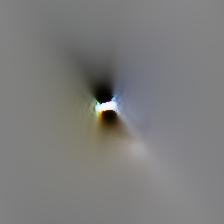
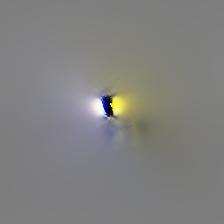
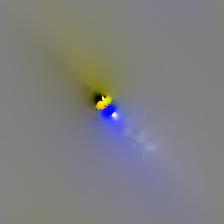
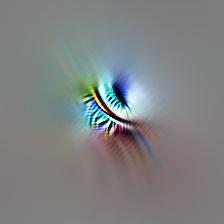
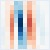
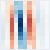
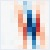
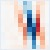
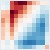
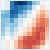
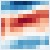
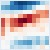
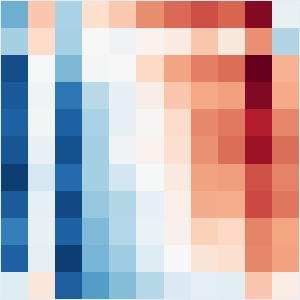
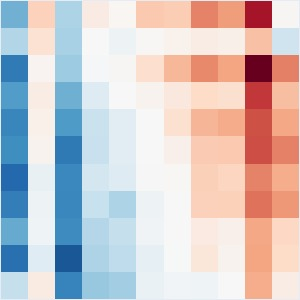
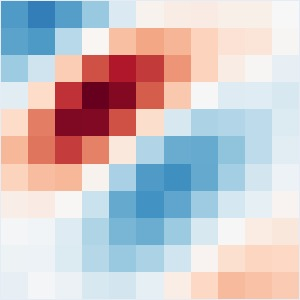
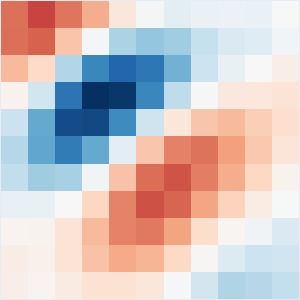
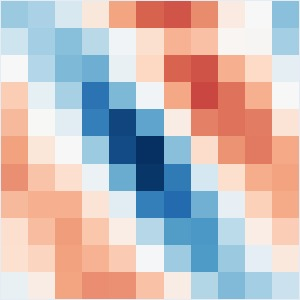
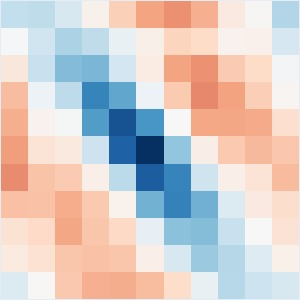
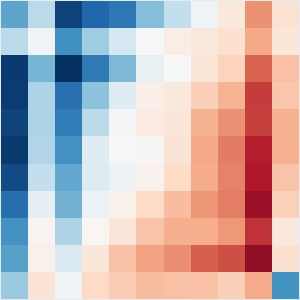
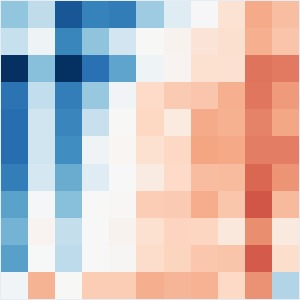
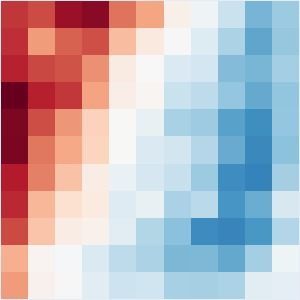
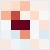
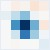
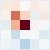
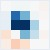
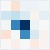
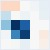
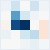
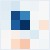

In [26]:
import base64
#fetch feature viz images on nodes
for layer in pos_dict_nodes:
    for i in range(len(pos_dict_nodes[layer]['name'])):
        nodeid = pos_dict_nodes[layer]['name'][i]
        img_file_path = './prepped_models/%s//visualizations/images/neuron/%s.jpg'%(prepped_model_folder,str(nodeid))
        img = base64.b64encode(open(img_file_path, 'rb').read())
        circuit_fig.add_layout_image(
            dict(
                source='data:image/jpg;base64,{}'.format(img.decode()),
                #source="http://chrishamblin.xyz/images/viscnn_images/%s.jpg"%nodeid,
                x=pos_dict_nodes[layer]['X'][i],
                y=pos_dict_nodes[layer]['Y'][i],
                sizex=1,
                sizey=1,
                name = nodeid
            ))

#fetch kernel images on edges
kernel_positions = []
for layer in pos_dict_edges:
    for i in range(len(pos_dict_edges[layer]['name'])):
        edgeid = pos_dict_edges[layer]['name'][i]
        gen_kernel_img(edgeid,kernels,params)
        img_file_path = './prepped_models/%s/visualizations/images/kernels/%s.jpg'%(prepped_model_folder,str(edgeid))
        img = base64.b64encode(open(img_file_path, 'rb').read())
        #getting best position
        best_dist=[0,0]
        for pos in [2,3,1,4]:
            far_enough_all=True
            smallest_dist = 1000000000
            for kernel_position in kernel_positions:
                dist, far_enough = min_distance(np.array([pos_dict_edges[layer]['X'][i][pos],pos_dict_edges[layer]['Y'][i][pos]]),np.array(kernel_position))
                if dist < smallest_dist:
                    smallest_dist=dist
                if not far_enough:
                    far_enough_all=False
            if far_enough_all:
                kernel_positions.append([pos_dict_edges[layer]['X'][i][pos],pos_dict_edges[layer]['Y'][i][pos]])
                break
            elif smallest_dist>best_dist[1]:
                best_dist = [pos,smallest_dist]
            if pos == 4:
                kernel_positions.append([pos_dict_edges[layer]['X'][i][best_dist[0]],pos_dict_edges[layer]['Y'][i][best_dist[0]]])
                    
        circuit_fig.add_layout_image(
            dict(
                source='data:image/jpg;base64,{}'.format(img.decode()),
                #source="http://chrishamblin.xyz/images/viscnn_images/%s.jpg"%nodeid,
                #x=pos_dict_edges[layer]['X'][i][2],
                #y=pos_dict_edges[layer]['Y'][i][2],
                x=kernel_positions[-1][0],
                y=kernel_positions[-1][1],
                sizex=.5,
                sizey=.5,
                name=edgeid,
                visible=True
            ))        
        

circuit_fig.update_layout_images(dict(
        xref="x",
        yref="y",
        xanchor="center",
        yanchor="middle"
))
    
circuit_fig.show()

In [27]:
from plotly.io import to_json

circuit_json = to_json(circuit_fig)

'{"data":[{"hoverinfo":"text","marker":{"color":["rgba(255,0,0,.7)","rgba(0,255,0,.7)","rgba(0,0,255,.7)"],"line":{"color":"rgb(50,50,50)","width":0.5},"opacity":0.99,"size":8,"symbol":"square"},"mode":"markers","name":"image channels","text":["r","g","b"],"type":"scatter","x":[-5,-5,-5],"y":[2,0,-2]},{"customdata":[[50.0,50.0,1.0],[56.0,56.0,0.5265068603794981],[38.0,38.0,0.3896398925434926],[47.0,47.0,0.3756413754212973],[28.0,28.0,0.2990399977967611],[43.0,43.0,0.29424985266743325],[34.0,34.0,0.2940277215832711],[49.0,49.0,0.27671341424294904]],"hovertemplate":"<b>%{customdata[0]}</b><br><i>layerwise ID</i>: %{customdata[1]}<br><i>Score</i>: %{customdata[2]:.3f}<br>","marker":{"color":"rgba(50,50,50,0)","line":{"color":"rgba(50,50,50,0)","width":0.5},"opacity":0,"size":6,"symbol":"circle"},"mode":"markers","name":"features_0","text":["50","56","38","47","28","43","34","49"],"type":"scatter","x":[0,0,0,0,0,0,0,0],"y":[-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5]},{"customdata":[[99.0,35.0,1.
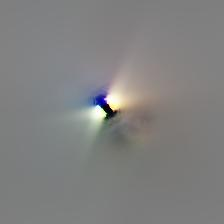
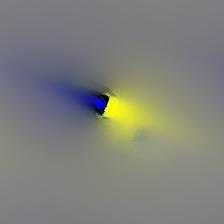
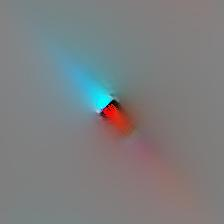
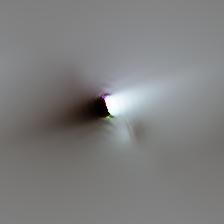
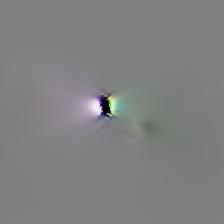
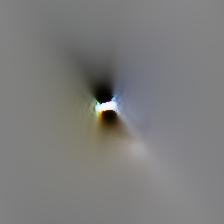
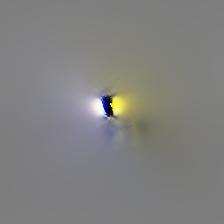
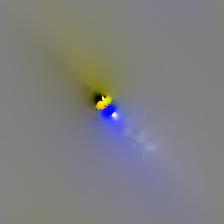
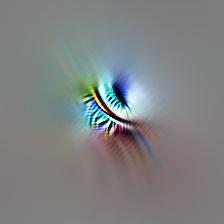
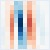
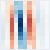
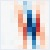
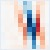
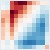
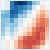
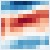
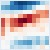
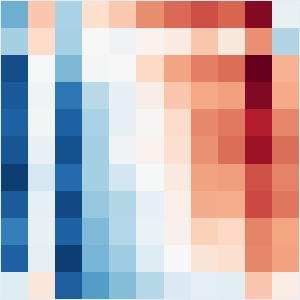
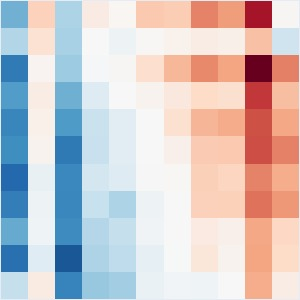
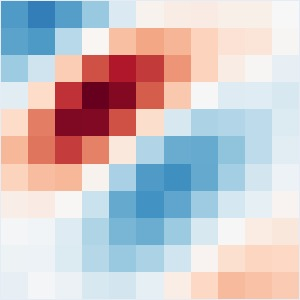
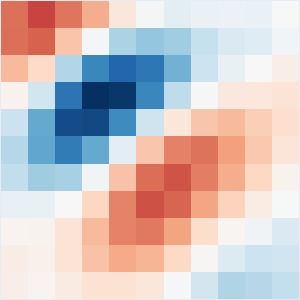
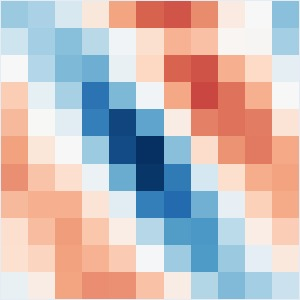
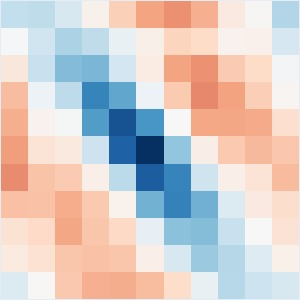
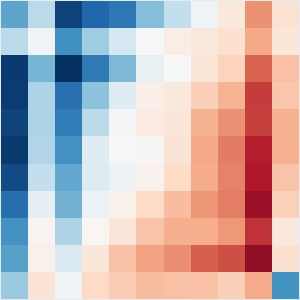
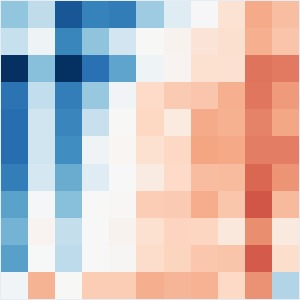
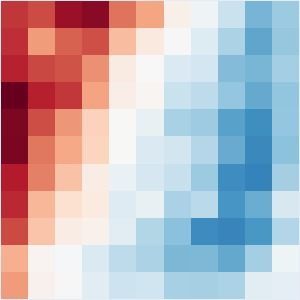
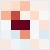
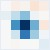
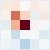
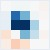
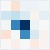
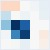
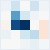
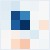

In [28]:
circuit_json

In [29]:
circuit_fig['data']


(Scatter({
     'hoverinfo': 'text',
     'marker': {'color': [rgba(255,0,0,.7), rgba(0,255,0,.7), rgba(0,0,255,.7)],
                'line': {'color': 'rgb(50,50,50)', 'width': 0.5},
                'opacity': 0.99,
                'size': 8,
                'symbol': 'square'},
     'mode': 'markers',
     'name': 'image channels',
     'text': [r, g, b],
     'x': [-5, -5, -5],
     'y': [2, 0, -2]
 }),
 Scatter({
     'customdata': array([[50.        , 50.        ,  1.        ],
                          [56.        , 56.        ,  0.52650686],
                          [38.        , 38.        ,  0.38963989],
                          [47.        , 47.        ,  0.37564138],
                          [28.        , 28.        ,  0.29904   ],
                          [43.        , 43.        ,  0.29424985],
                          [34.        , 34.        ,  0.29402772],
                          [49.        , 49.        ,  0.27671341]]),
     'hovertemplate': ('<b>%{customdata[0

In [30]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.exceptions import PreventUpdate
#import utils.dash_reusable_components as drc
import flask
import os

import json

from dash.dependencies import Input, Output, State

from plotly.subplots import make_subplots

from flask_caching import Cache



#external_stylesheets = ['https://codepen.io/amyoshino/pen/jzXypZ.css']
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(external_stylesheets = external_stylesheets)


styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}


theme =  {
    'dark': True,
    'detail': '#007439',
    'primary': '#00EA64',
    'secondary': '#6E6E6E',
}




state = {'select':False}

app.layout = html.Div([
        html.Div(
            children = [
                html.Label('Feature Size'),
                dcc.Slider(
                        id='feat_size',
                        min=.1,
                        max=3,
                        step=0.0005,
                        value = 1
                    ),
                html.Label('Kernel Size'),
                dcc.Slider(
                        id='kernel_size',
                        min=.05,
                        max=2,
                        step=0.0005,
                        value = .5
                    )
                ], className="three columns",
                ),
                
            html.Div([
                dcc.Graph(
                    id='fig',
                    figure=circuit_fig
                )
                ], className= 'nine columns'
                ),
            dcc.Store(id='memory',data=state)
            ], className="row")




#Network Graph Figure
@app.callback(
    Output('fig', 'figure'),
    [Input('feat_size', 'value'),
     Input('kernel_size','value'),
     Input('fig', 'clickData')],
    [State('fig','figure')])
def update_figure(feat_size, kernel_size, clickData, fig):
    print(clickData)
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    print(trigger)
    
    if trigger in ['feat_size.value','kernel_size.value']:
        for i in range(len(fig['layout']['images'])):
            if '-' not in fig['layout']['images'][i]['name']:
                fig['layout']['images'][i]['sizex'] = feat_size
                fig['layout']['images'][i]['sizey'] = feat_size
            else:
                fig['layout']['images'][i]['sizex'] = kernel_size
                fig['layout']['images'][i]['sizey'] = kernel_size
                
    
    #highlight graph
    elif fig['data'][-1]['text'] == 'full':
        
        click_name = circuit2d_curve_2_id(clickData['points'][0]['curveNumber'],clickData['points'][0]['pointNumber'],subgraph_dict,params)
        highlight = {'nodes':[],'edges':[]}
        #edge clicked
        if '-' in click_name:
            highlight['edges'].append(click_name)
            highlight['nodes'].append(click_name.split('-')[0])
            highlight['nodes'].append(click_name.split('-')[1])
        #node clicked
        else:
            highlight['nodes'].append(click_name)
            layer,within_layer_id,layer_name = nodeid_2_perlayerid(click_name,params)
            for row in subgraph_dict['edge_df'].itertuples():
                if row.layer == layer and row.out_channel==within_layer_id:
                    if row.layer != 0:
                        in_node = params['layer_nodes'][row.layer-1][1][row.in_channel]
                    else:
                        in_node = params['imgnode_names'][row.in_channel]
                    highlight['edges'].append(str(in_node)+'-'+str(click_name))
                    highlight['nodes'].append(str(in_node))
                if row.layer == int(layer)+1 and row.in_channel==int(within_layer_id):
                    out_node = params['layer_nodes'][row.layer][1][row.out_channel]
                    highlight['edges'].append(str(click_name)+'-'+str(out_node))
                    highlight['nodes'].append(str(out_node))
        #highlight from highlight dict
        #print(highlight)
        for i in range(len(fig['data'])-1):
            if i == 0:
                op = []
                for c in ['r','g','b']:
                    if c in highlight['nodes']:
                        op.append(.99)
                    else:
                        op.append(.1)
                fig['data'][i]['marker']['opacity'] = op
            #if i <= len(subgraph_dict['node_df']['layer'].unique()):
            #    op = []
            #    for n in fig['data'][i]['text']:
            #        if n in highlight['nodes']:
            #            op.append(.99)
            #        else:
            #            op.append(.1)
            elif i > len(subgraph_dict['node_df']['layer'].unique()):
                old_color = fig['data'][i]['line']['color']
                if fig['data'][i]['text'] in highlight['edges']:
                    new_color = ','.join(old_color.split(',')[:-1])+',1)'  #makes opacity full
                else:
                    new_color = ','.join(old_color.split(',')[:-1])+',.1)'
                fig['data'][i]['line']['color'] = new_color
        for i in range(len(fig['layout']['images'])):
            if fig['layout']['images'][i]['name'] in highlight['edges'] or fig['layout']['images'][i]['name'] in highlight['nodes']:
                fig['layout']['images'][i]['visible'] = True
            else:
                fig['layout']['images'][i]['visible'] = False
        fig['data'][-1]['text'] = 'partial'
    #reset opacity
    else:
        print('resetting graph opacity')
        for i in range(len(fig['data'])-1):
            if i == 0:
                fig['data'][i]['marker']['opacity'] = .99
            elif i > len(subgraph_dict['node_df']['layer'].unique()):
                old_color = fig['data'][i]['line']['color']
                new_color = ','.join(old_color.split(',')[:-1])+',1)'  #makes opacity full
                fig['data'][i]['line']['color'] = new_color
        for i in range(len(fig['layout']['images'])):
            fig['layout']['images'][i]['visible'] = True
        fig['data'][-1]['text'] = 'full'
    return fig

In [ ]:
app.run_server(port=8051)

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8051/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_1m1617985068.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_1m1617985068.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET /_dash-component-suites/dash_daq/dash_daq.v0_5_0m1596869724.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_16_0m1617985098.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2021 15:28:48] "GET /_dash-compone

None
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/da

127.0.0.1 - - [07/Jul/2021 15:28:51] "POST /_dash-update-component HTTP/1.1" 500 -


In [40]:
circuit_fig['data']

(Scatter({
     'hoverinfo': 'text',
     'marker': {'color': [rgba(255,0,0,.7), rgba(0,255,0,.7), rgba(0,0,255,.7)],
                'line': {'color': 'rgb(50,50,50)', 'width': 0.5},
                'opacity': 0.99,
                'size': 8,
                'symbol': 'square'},
     'mode': 'markers',
     'name': 'image channels',
     'text': [r, g, b],
     'x': [-5, -5, -5],
     'y': [2, 0, -2]
 }),
 Scatter({
     'customdata': array([[50.        , 50.        ,  1.        ],
                          [56.        , 56.        ,  0.52650686],
                          [38.        , 38.        ,  0.38963989],
                          [47.        , 47.        ,  0.37564138],
                          [28.        , 28.        ,  0.29904   ],
                          [43.        , 43.        ,  0.29424985],
                          [34.        , 34.        ,  0.29402772],
                          [49.        , 49.        ,  0.27671341]]),
     'hovertemplate': ('<b>%{customdata[0

In [31]:
pos_dict

{0: {'nodes': [21, 37], 'xs': [0, 0], 'ys': [-0.5, 0.5]},
 1: {'nodes': [75, 198, 244], 'xs': [5, 5, 5], 'ys': [-1.0, 0.0, 1.0]},
 2: {'nodes': [435], 'xs': [10], 'ys': [0.0]}}

In [34]:
params['layer_nodes'][2][1][6]

262

In [47]:
for row in edge_df.loc[edge_df['layer']==layer]:
    print(row)

edge_num
layer_name
layer
out_channel
in_channel
act_rank
grad_rank
actxgrad_rank


In [ ]:
def minmax_normalize_between_values(vec,min_v,max_v):
    return (max_v-min_v)*(vec-np.min(vec))/(np.max(vec)-np.min(vec))+min_v


subgraph_dict['edge_df']